In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images_folder = '/content/drive/MyDrive/171/Images/images'
images = 'Images'

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/171/images_gz2.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/97514.jpg        
  inflating: __MACOSX/images/._97514.jpg  
  inflating: images/97515.jpg        
  inflating: __MACOSX/images/._97515.jpg  
  inflating: images/97516.jpg        
  inflating: __MACOSX/images/._97516.jpg  
  inflating: images/97517.jpg        
  inflating: __MACOSX/images/._97517.jpg  
  inflating: images/97518.jpg        
  inflating: __MACOSX/images/._97518.jpg  
  inflating: images/97519.jpg        
  inflating: __MACOSX/images/._97519.jpg  
  inflating: images/9752.jpg         
  inflating: __MACOSX/images/._9752.jpg  
  inflating: images/97520.jpg        
  inflating: __MACOSX/images/._97520.jpg  
  inflating: images/97521.jpg        
  inflating: __MACOSX/images/._97521.jpg  
  inflating: images/97523.jpg        
  inflating: __MACOSX/images/._97523.jpg  
  inflating: images/97524.jpg        
  inflating: __MACOSX/images/._97524.jpg  
  inflating: images/97525.jpg        
  inflating: __MACOSX

In [ ]:
import os

df = pd.read_csv("/content/drive/MyDrive/171/gz2_hart16.csv")
mapping = pd.read_csv("/content/drive/MyDrive/171/gz2_filename_mapping.csv")

# Step 2: Filter smooth galaxies
smooth = df[
    (df['t01_smooth_or_features_a01_smooth_count'] > 10) &
    (df['t01_smooth_or_features_a01_smooth_fraction'] > 0.75)
].copy()
smooth['label'] = 0  # smooth

# Step 3: Filter featured galaxies
featured = df[
    (df['t01_smooth_or_features_a02_features_or_disk_count'] > 10) &
    (df['t01_smooth_or_features_a02_features_or_disk_fraction'] > 0.75)
].copy()
featured['label'] = 1  # featured

print(f"Class 0 (label=0) samples: {len(smooth)}")
print(f"Class 1 (label=1) samples: {len(featured)}")

# Step 4: Combine both sets
combined = pd.concat([smooth, featured], ignore_index=True)
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced: Class 0 (label=0) samples: {len(smooth)}")
print(f"Balanced: Class 1 (label=1) samples: {len(featured)}")


# Rename objid to dr7objid for merging convenience
mapping = mapping.rename(columns={'objid': 'dr7objid'})

# Now merge using dr7objid
merged = combined.merge(mapping[['dr7objid', 'asset_id']], on='dr7objid', how='left')

# Add file path
merged['file_path'] = "/content/images/" + merged['asset_id'].astype(str) + ".jpg"

# Optional: Check for missing mappings
missing = merged['file_path'].isnull().sum()
print(f"Missing file paths for {missing} rows")

# Keep only desired columns
final_df = merged[['dr7objid', 'label', 'file_path']]

# Check if the file exists for each file_path
final_df['exists'] = final_df['file_path'].apply(os.path.exists)

# Keep only rows where the image file exists
final_df = final_df[final_df['exists']].drop(columns=['exists'])

# Print how many files were kept
print(f"Remaining entries with valid images: {len(final_df)}")

# Save to new CSV
final_df.to_csv("gz2_filtered_labeled.csv", index=False)

Class 0 (label=0) samples: 122158
Class 1 (label=1) samples: 32506
Balanced: Class 0 (label=0) samples: 122158
Balanced: Class 1 (label=1) samples: 32506
Missing file paths for 0 rows


<ipython-input-7-87993fe5c2ea>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['exists'] = final_df['file_path'].apply(os.path.exists)


Remaining entries with valid images: 154633


In [ ]:
# Keep only relevant columns
final_df = merged[['dr7objid', 'label', 'file_path']]

# Print number of entries
print(f"Total rows in filtered CSV: {len(final_df)}")

In [ ]:
from sklearn.model_selection import train_test_split

# Load the filtered CSV
df = pd.read_csv("gz2_filtered_labeled.csv")

# First split: train vs temp (val+test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Second split: validation vs test (half of temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print counts
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Optionally save to CSVs
train_df.to_csv("train_set.csv", index=False)
val_df.to_csv("val_set.csv", index=False)
test_df.to_csv("test_set.csv", index=False)


In [ ]:
train_paths = train_df['file_path']
train_labels = train_df['label']

val_paths = val_df['file_path']
val_labels = val_df['label']

test_paths = test_df['file_path']
test_labels = test_df['label']

In [ ]:
import numpy as np
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(1.0)  # 1.0 means up to 360 degrees
    ])



def load_image(path, label, target_size=(424, 424), augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        image = data_augmentation(image)

    image.set_shape([target_size[0], target_size[1], 3])
    return image, label


def build_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: load_image(p, l, augment=augment), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Build datasets
train_ds = build_dataset(train_paths, train_labels, shuffle=True, augment=True)
val_ds   = build_dataset(val_paths, val_labels)
test_ds  = build_dataset(test_paths, test_labels)

In [ ]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 424, 424, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
from keras import layers, models

In [ ]:
from tensorflow.keras import layers, models

def CNN(input_shape=(424, 424, 3), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),

        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model


In [ ]:
import numpy as np

def extract_features(dataset):
    features = []
    labels = []

    for images, lbls in dataset:
        # Preprocess images as required by ResNet
        images = preprocess_input(images.numpy())
        vecs = base_model.predict(images)
        features.append(vecs)
        labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet without the final dense layers
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(424, 424, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def Random_forest(train_ds, val_ds, test_ds):
  X_train, y_train = extract_features(train_ds)
  X_val, y_val = extract_features(val_ds)
  X_test, y_test = extract_features(test_ds)
  with tf.device('/device:GPU:0'):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
  print(classification_report(y_test, y_pred, target_names=["Smooth", "Featured"]))

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/4
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 592s 328ms/step - accuracy: 0.8620 - loss: 0.3193 - val_accuracy: 0.9040 - val_loss: 0.2265
Epoch 2/4
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 539s 317ms/step - accuracy: 0.9131 - loss: 0.2125 - val_accuracy: 0.9039 - val_loss: 0.2323
Epoch 3/4
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 539s 316ms/step - accuracy: 0.9198 - loss: 0.1963 - val_accuracy: 0.9227 - val_loss: 0.2002
Epoch 4/4
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 540s 317ms/step - accuracy: 0.9310 - loss: 0.1760 - val_accuracy: 0.9505 - val_loss: 0.1345


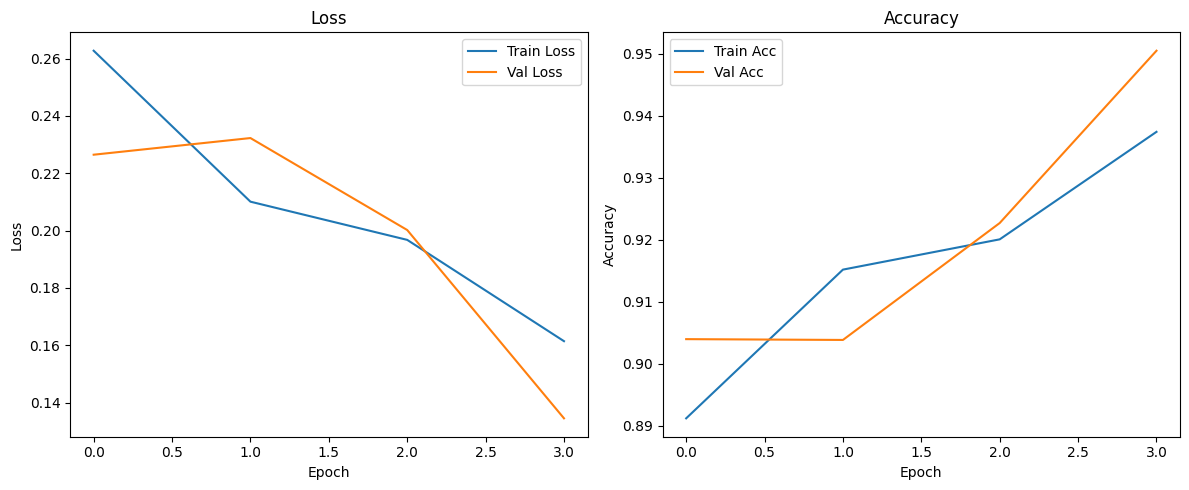

In [ ]:
model = CNN()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = None

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=4,
    )

    model.save("smooth_feature.keras")

    plot_training_history(history)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

363/363 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9494 - loss: 0.1342
Test Loss: 0.1372
Test Accuracy: 0.9484


In [ ]:
Random_forest(train_ds, val_ds, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━

In [ ]:
def binary_csvs(count1, fraction1, count2, fraction2, csv_name, c_t=10, v_t=0.75):
  df = pd.read_csv("/content/drive/MyDrive/171/gz2_hart16.csv")
  mapping = pd.read_csv("/content/drive/MyDrive/171/gz2_filename_mapping.csv")

  # Get valid first feature examples
  class1 = df[
      (df[count1] > c_t) &
      (df[fraction1] > v_t)
  ].copy()
  class1['label'] = 0

  # Valid second features exambples
  class2 = df[
      (df[count2] > c_t) &
      (df[fraction2] > v_t)
  ].copy()
  class2['label'] = 1

  print(f"Class 0 (label=0) samples: {len(class1)}")
  print(f"Class 1 (label=1) samples: {len(class2)}")


  # Balance
  min_len = min(len(class1), len(class2))
  class1 = class1.sample(n=min_len, random_state=42)
  class2 = class2.sample(n=min_len, random_state=42)

  print(f"Class 0 (label=0) samples: {len(class1)}")
  print(f"Class 1 (label=1) samples: {len(class2)}")


  # Combine
  combined = pd.concat([class1, class2], ignore_index=True)
  combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

  # Add file path
  # - For the file mapping since the key of the original dataset != file names
  # - Included in the gz2 website
  mapping = mapping.rename(columns={'objid': 'dr7objid'})
  merged = combined.merge(mapping[['dr7objid', 'asset_id']], on='dr7objid', how='left')
  merged['file_path'] = "/content/images/" + merged['asset_id'].astype(str) + ".jpg"

  # Missing mappings
  missing = merged['file_path'].isnull().sum()
  print(f"Missing file paths for {missing} rows")

  # Finalize
  # - Some files in the gz2 csv are "extra" and therefore not included in the dataset
  final_df = merged[['dr7objid', 'label', 'file_path']]
  final_df['exists'] = final_df['file_path'].apply(os.path.exists)
  final_df = final_df[final_df['exists']].drop(columns=['exists'])

  # Print how many files were kept
  print(f"Remaining entries with valid images: {len(final_df)}")

  # Save csv for later use
  final_df.to_csv(csv_name, index=False)


In [ ]:
def get_train_val_test(csv_name, feature):
  # Load the filtered CSV
  df = pd.read_csv(csv_name)

  # First split: train vs temp (val+test)
  train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

  # Second split: validation vs test (half of temp)
  val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

  # Print counts
  print(f"Train size: {len(train_df)}")
  print(f"Validation size: {len(val_df)}")
  print(f"Test size: {len(test_df)}")

  train_paths = train_df['file_path']
  train_labels = train_df['label']

  val_paths = val_df['file_path']
  val_labels = val_df['label']

  test_paths = test_df['file_path']
  test_labels = test_df['label']

  # Build datasets
  train_ds = build_dataset(train_paths, train_labels, shuffle=True, augment=True)
  val_ds   = build_dataset(val_paths, val_labels)
  test_ds  = build_dataset(test_paths, test_labels)

  return train_ds, val_ds, test_ds

In [ ]:
csv = "gz2_filtered_edge.csv"
binary_csvs("t02_edgeon_a04_yes_count",
            "t02_edgeon_a04_yes_debiased",
            "t02_edgeon_a05_no_count",
            "t02_edgeon_a05_no_debiased",
            csv,
            15,
            0.8
            )

Class 0 (label=0) samples: 10038
Class 1 (label=1) samples: 57243
Class 0 (label=0) samples: 10038
Class 1 (label=1) samples: 10038
Missing file paths for 0 rows
Remaining entries with valid images: 20076


<ipython-input-8-8c73ab994748>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['exists'] = final_df['file_path'].apply(os.path.exists)


In [ ]:
train_ds, val_ds, test_ds = get_train_val_test(csv, "edge")

Train size: 14053
Validation size: 3011
Test size: 3012


Epoch 1/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 97s 404ms/step - accuracy: 0.5439 - loss: 0.6750 - val_accuracy: 0.8183 - val_loss: 0.4396
Epoch 2/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 305ms/step - accuracy: 0.8361 - loss: 0.3914 - val_accuracy: 0.8944 - val_loss: 0.2675
Epoch 3/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - accuracy: 0.9005 - loss: 0.2534 - val_accuracy: 0.8904 - val_loss: 0.2849
Epoch 4/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - accuracy: 0.9130 - loss: 0.2214 - val_accuracy: 0.9449 - val_loss: 0.1482
Epoch 5/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - accuracy: 0.9293 - loss: 0.1916 - val_accuracy: 0.9459 - val_loss: 0.1841
Epoch 6/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 305ms/step - accuracy: 0.9368 - loss: 0.1707 - val_accuracy: 0.9465 - val_loss: 0.1360


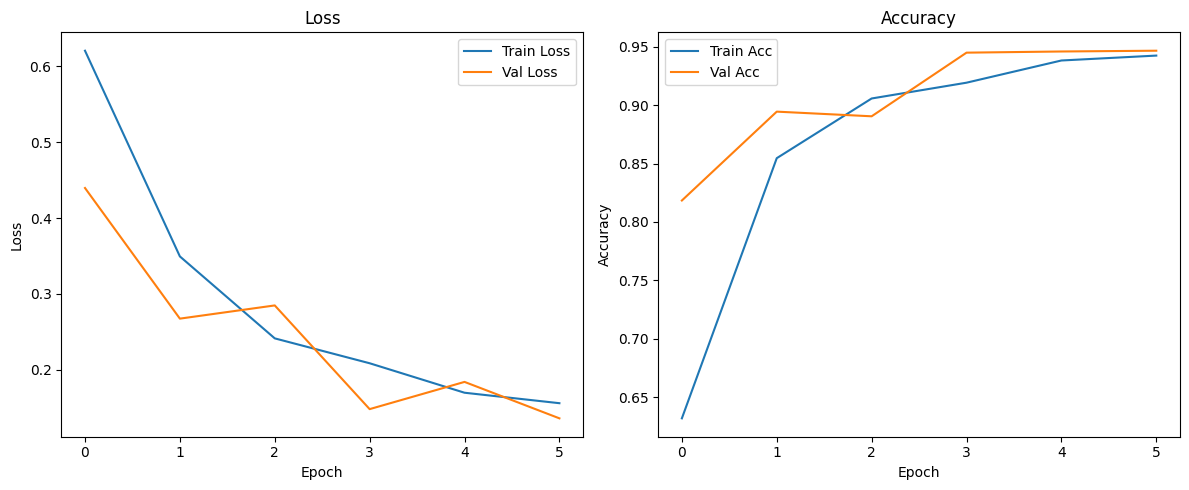

In [ ]:
edge_model = CNN()
edge_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = None

with tf.device('/device:GPU:0'):
    history = edge_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=6,
    )

    edge_model.save("edge.keras")

    plot_training_history(history)

In [ ]:
loss, accuracy = edge_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9536 - loss: 0.1172
Test Loss: 0.1224
Test Accuracy: 0.9515


In [ ]:
Random_forest(train_ds, val_ds, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━

In [ ]:
csv = "gz2_filtered_bar.csv"
binary_csvs("t03_bar_a06_bar_count",
            "t03_bar_a06_bar_weighted_fraction",
            "t03_bar_a07_no_bar_count",
            "t03_bar_a07_no_bar_weighted_fraction",
            csv,
            15,
            0.8)

Class 0 (label=0) samples: 5457
Class 1 (label=1) samples: 26137
Class 0 (label=0) samples: 5457
Class 1 (label=1) samples: 5457
Missing file paths for 0 rows
Remaining entries with valid images: 10913


<ipython-input-8-8c73ab994748>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['exists'] = final_df['file_path'].apply(os.path.exists)


In [ ]:
train_ds, val_ds, test_ds = get_train_val_test(csv, "bar")

Train size: 7639
Validation size: 1637
Test size: 1637


Epoch 1/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 433ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.5437 - val_loss: 0.6771
Epoch 2/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 292ms/step - accuracy: 0.5971 - loss: 0.6733 - val_accuracy: 0.6396 - val_loss: 0.6401
Epoch 3/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 295ms/step - accuracy: 0.6324 - loss: 0.6550 - val_accuracy: 0.6384 - val_loss: 0.6587
Epoch 4/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 294ms/step - accuracy: 0.6383 - loss: 0.6543 - val_accuracy: 0.6671 - val_loss: 0.6292
Epoch 5/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - accuracy: 0.6504 - loss: 0.6409 - val_accuracy: 0.6555 - val_loss: 0.6429
Epoch 6/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step - accuracy: 0.6520 - loss: 0.6397 - val_accuracy: 0.6512 - val_loss: 0.6248


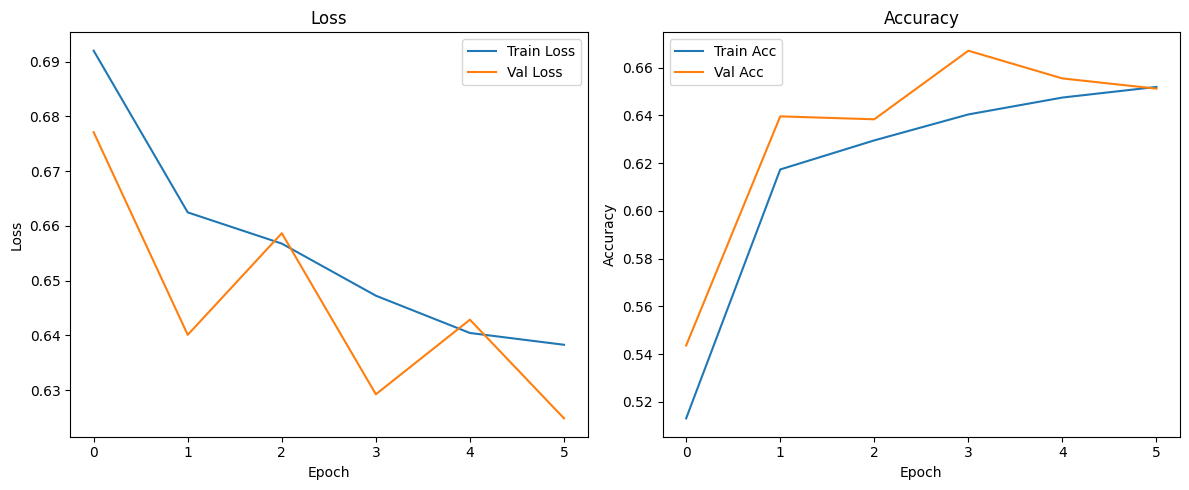

In [ ]:
bar_model = CNN()
bar_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = None

with tf.device('/device:GPU:0'):
    history = bar_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=6,
    )

    bar_model.save("bar.keras")

    plot_training_history(history)

In [ ]:
Random_forest(train_ds, val_ds, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━

In [ ]:
csv = "gz2_filtered_spiral.csv"
binary_csvs("t04_spiral_a08_spiral_count",
            "t04_spiral_a08_spiral_weighted_fraction",
            "t04_spiral_a09_no_spiral_count",
            "t04_spiral_a09_no_spiral_weighted_fraction",
            csv)

Class 0 (label=0) samples: 35858
Class 1 (label=1) samples: 7316
Class 0 (label=0) samples: 7316
Class 1 (label=1) samples: 7316
Missing file paths for 0 rows
Remaining entries with valid images: 14628


<ipython-input-8-8c73ab994748>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['exists'] = final_df['file_path'].apply(os.path.exists)


In [ ]:
train_ds, val_ds, test_ds = get_train_val_test(csv, "spiral")

Train size: 10239
Validation size: 2194
Test size: 2195


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 504ms/step - accuracy: 0.5278 - loss: 0.6893 - val_accuracy: 0.6791 - val_loss: 0.6275
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 305ms/step - accuracy: 0.7067 - loss: 0.5861 - val_accuracy: 0.7074 - val_loss: 0.5926
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 309ms/step - accuracy: 0.7191 - loss: 0.5686 - val_accuracy: 0.6878 - val_loss: 0.6133
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 304ms/step - accuracy: 0.7150 - loss: 0.5665 - val_accuracy: 0.7325 - val_loss: 0.5464
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - accuracy: 0.7301 - loss: 0.5464 - val_accuracy: 0.7252 - val_loss: 0.5596
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - accuracy: 0.7296 - loss: 0.5403 - val_accuracy: 0.7279 - val_loss: 0.5530
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 302ms/step - accuracy: 0.7357 - loss: 0.5375 - val_accuracy: 0.7402 - val_loss: 0.5405
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 302ms/step - accuracy: 0.7355 - loss: 0

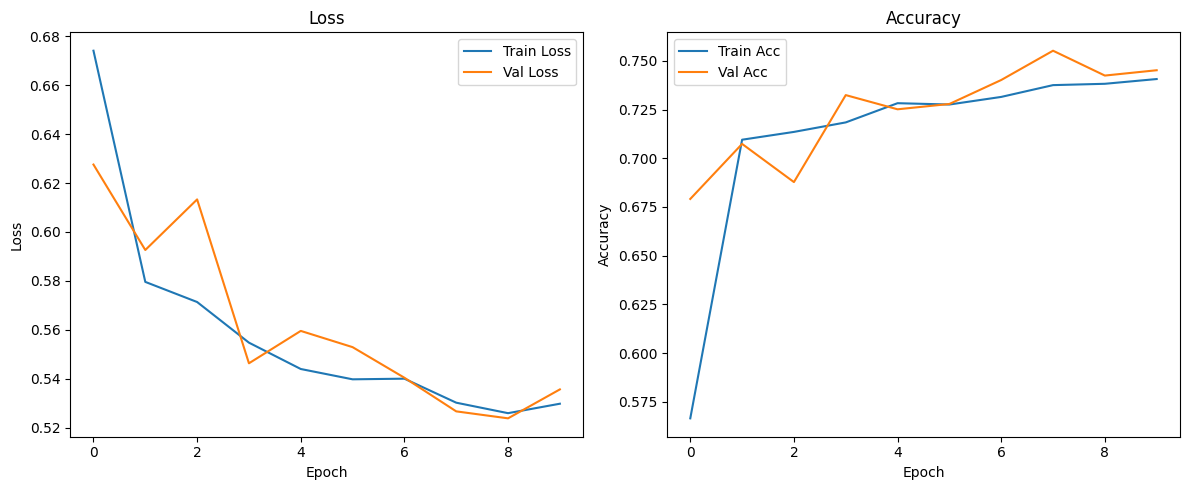

In [ ]:
bar_model = CNN()
bar_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = None

with tf.device('/device:GPU:0'):
    history = bar_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
    )

    bar_model.save("bar.keras")

    plot_training_history(history)

In [ ]:
Random_forest(train_ds, val_ds, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━

In [ ]:
def CNN_2(input_shape=(424, 424, 3), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(32, activation='relu'),

        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model


In [ ]:
bar_reverse_model = CNN_2()
bar_reverse_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = None

with tf.device('/device:GPU:0'):
    history = bar_reverse_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
    )

    bar_reverse_model.save("bar_reverse.keras")

    plot_training_history(history)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 205s 888ms/step - accuracy: 0.5032 - loss: 0.6932 - val_accuracy: 0.4986 - val_loss: 0.6849
Epoch 2/10
 14/160 ━━━━━━━━━━━━━━━━━━━━ 1:07 465ms/step - accuracy: 0.5318 - loss: 0.6756

KeyboardInterrupt: 

In [ ]:
Random_forest(train_ds, val_ds, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━

In [ ]:
from sklearn.ensemble import RandomForestClassifier
with tf.device('/device:GPU:0'):
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Smooth", "Featured"]))

              precision    recall  f1-score   support

      Smooth       0.63      0.72      0.67      1098
    Featured       0.67      0.57      0.62      1097

    accuracy                           0.64      2195
   macro avg       0.65      0.64      0.64      2195
weighted avg       0.65      0.64      0.64      2195

